### 1. Example for list of strings as documents

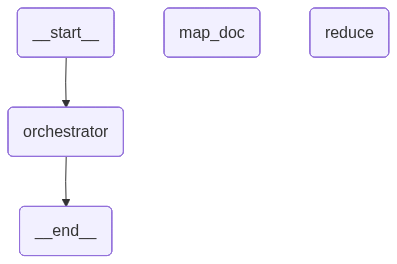

In [5]:
# langgraph_mapreduce_wordcount.py
from typing import TypedDict, List, Dict, Annotated
from operator import add
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send, Command
from langgraph.checkpoint.memory import InMemorySaver

class AggregateState(TypedDict, total=False):
    docs: List[str]

    # Annotating partials with a reducer (list concatenation)
    partials: Annotated[List[Dict[str, int]], add]
    final_counts: Dict[str, int]

class WorkerState(TypedDict):
    doc: str

def orchestrator(state: AggregateState) -> Command:
    docs = state.get("docs", []) or []
    sends = [Send("map_doc", {"doc": d}) for d in docs]

    # Return a command that dispatches multiple sends
    return Command(update={}, goto=sends)

def map_doc(state: WorkerState) -> Dict[str, List[Dict[str, int]]]:
    text = state.get("doc", "")
    counts: Dict[str, int] = {}
    for token in text.split():
        w = token.lower().strip(".,!?:;\"'()[]")
        if not w:
            continue
        counts[w] = counts.get(w, 0) + 1
    
    # Return as a one-element list under 'partials' so reducer concatenates lists
    return {"partials": [counts]}

def reducer(state: AggregateState) -> Dict[str, Dict[str, int]]:
    final: Dict[str, int] = {}
    for part in state.get("partials", []):
        for word, cnt in part.items():
            final[word] = final.get(word, 0) + cnt
    return {"final_counts": final}

def build_mapreduce_graph() -> StateGraph:
    builder = StateGraph(AggregateState)

    builder.add_node("orchestrator", orchestrator)
    builder.add_node("map_doc", map_doc)
    builder.add_node("reduce", reducer)

    builder.add_edge(START, "orchestrator")

    # map_doc results feed into reduce
    builder.add_edge("map_doc", "reduce")
    builder.add_edge("reduce", END)

    graph = builder.compile(checkpointer=InMemorySaver())
    return graph
graph = build_mapreduce_graph()
graph

### Why in the above diagram  `map_doc`  and  `reduce` not connect?

### Because Langgraph graph diagram does not show dynamic fan-out edges created using Send. These edeges exist only at runtime

In [10]:
if __name__ == "__main__":
    docs = [
        "Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        "Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        "Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
    ]
    initial_state: AggregateState = {
        "docs": docs,
        "partials": [],
        "final_counts": {}
    }

    graph = build_mapreduce_graph()
    config = {"configurable": {"thread_id": "mapreduce_example_1"}}

    # invoke the graph (runs the orchestrator -> map -> reduce)
    graph.invoke(initial_state, config=config)

    # get the final StateSnapshot
    snapshot = graph.get_state(config)

    # IMPORTANT: snapshot is a StateSnapshot object - values are in snapshot.values
    final_counts = snapshot.values.get("final_counts", {})

    print("Final word counts:", final_counts)

Final word counts: {'peak': 3, 'performance': 3, 'gym': 5, 'was': 1, 'founded': 1, 'in': 2, '2015': 1, 'by': 1, 'former': 1, 'olympic': 1, 'athlete': 1, 'marcus': 2, 'chen': 1, 'with': 2, 'over': 1, '15': 1, 'years': 1, 'of': 2, 'experience': 1, 'professional': 1, 'athletics': 1, 'established': 1, 'the': 5, 'to': 3, 'provide': 1, 'personalized': 1, 'fitness': 2, 'solutions': 1, 'for': 1, 'people': 1, 'all': 1, 'levels': 1, 'spans': 1, '10,000': 1, 'square': 1, 'feet': 1, 'and': 4, 'features': 1, 'state-of-the-art': 1, 'equipment': 1, 'is': 2, 'open': 1, 'monday': 2, 'through': 1, 'friday': 1, 'from': 1, '5:00': 1, 'am': 2, '11:00': 1, 'pm': 3, 'on': 3, 'weekends': 1, 'our': 2, 'hours': 1, 'are': 3, '7:00': 1, '9:00': 1, 'we': 1, 'remain': 1, 'closed': 1, 'major': 1, 'national': 1, 'holidays': 2, 'members': 1, 'premium': 1, 'access': 1, 'can': 1, 'enter': 1, 'using': 1, 'their': 1, 'key': 1, 'cards': 1, '24/7': 1, 'including': 1, 'group': 1, 'classes': 3, 'at': 3, 'include': 1, 'yoga': 

### 2. Example for applying map_reduce to a pdf file

In [ ]:
from typing import TypedDict, List, Dict, Annotated
from operator import add
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send, Command
from langgraph.checkpoint.memory import InMemorySaver

class AggregateState(TypedDict, total=False):
    docs: List[str]

    # Annotating partials with a reducer (list concatenation)
    partials: Annotated[List[Dict[str, int]], add]
    final_counts: Dict[str, int]

class WorkerState(TypedDict):
    doc: str

def orchestrator(state: AggregateState) -> Command:
    docs = state.get("docs", []) or []
    sends = [Send("map_doc", {"doc": d}) for d in docs]

    # Return a command that dispatches multiple sends
    return Command(update={}, goto=sends)

def map_doc(state: WorkerState) -> Dict[str, List[Dict[str, int]]]:
    text = state.get("doc", "")
    counts: Dict[str, int] = {}
    for token in text.split():
        w = token.lower().strip(".,!?:;\"'()[]")
        if not w:
            continue
        counts[w] = counts.get(w, 0) + 1
    
    # Return as a one-element list under 'partials' so reducer concatenates lists
    return {"partials": [counts]}

def reducer(state: AggregateState) -> Dict[str, Dict[str, int]]:
    final: Dict[str, int] = {}
    for part in state.get("partials", []):
        for word, cnt in part.items():
            final[word] = final.get(word, 0) + cnt
    return {"final_counts": final}

def build_mapreduce_graph() -> StateGraph:
    builder = StateGraph(AggregateState)

    builder.add_node("orchestrator", orchestrator)
    builder.add_node("map_doc", map_doc)
    builder.add_node("reduce", reducer)

    builder.add_edge(START, "orchestrator")

    # map_doc results feed into reduce
    builder.add_edge("map_doc", "reduce")
    builder.add_edge("reduce", END)

    graph = builder.compile(checkpointer=InMemorySaver())
    return graph
graph = build_mapreduce_graph()
graph

In [11]:
if __name__ == "__main__":
    folder = r"/Users/manmathtiwari/Desktop/My Projects/LangGraph Projects/pdfs"

    print("Loading PDFs...")
    docs = load_pdfs_as_chunks(folder, chunk_size=1000)

    print(f"Total chunks for Map-Reduce: {len(docs)}")

    initial_state: AggregateState = {
        "docs": docs,
        "partials": [],
        "final_counts": {}
    }

    graph = build_mapreduce_graph()
    config = {"configurable": {"thread_id": "pdf_mr_wordcount"}}

    graph.invoke(initial_state, config=config)

    snapshot = graph.get_state(config)
    final_counts = snapshot.values.get("final_counts", {})

    print("\n=============")
    print("FINAL WORD COUNTS:")
    print("=============\n")

    # print top 30 words
    sorted_words = sorted(final_counts.item(), key=lambda x: x[1], reverse=True)
    for w, c in sorted_words[:30]:
        print(f"{w:<20} {c}")

Loading PDFs...


NameError: name 'load_pdfs_as_chunks' is not defined